<a href="https://colab.research.google.com/github/fsilvestrim/thesis/blob/master/Geo_Cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utils

In [1]:
import re
import time
import random
import numpy as np
import scipy as sp
import pickle
import hashlib
import math

import PIL
import cv2 as cv

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from tqdm import tqdm 

from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from IPython.display import Image, display

np.seterr(divide='ignore', invalid='ignore')

%matplotlib inline

In [2]:
#%tensorflow_version 2.x

import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution

#disable_eager_execution()
enable_eager_execution()
print('Eager mode: %s' % tf.executing_eagerly())

device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

2.4.1
Eager mode: True
Found GPU at: /device:GPU:0


In [3]:
def safe_divide(a, b, abs=True):
  val = 0

  if b != 0 and not math.isnan(b):
    val = np.divide(a, b)

  return np.int0(val) if abs else val

In [4]:
def resize_image(image, size):
  height_zoom = size[1] / image.shape[0]
  width_zoom = size[0] / image.shape[1]
  image = sp.ndimage.zoom(image, (height_zoom, width_zoom), order=2)

  return image

In [5]:
def show_image(img, size, title=None, ax=None, alpha=1, cmap='Greys', stacked_imgs=[]):
  img = img.reshape(size[0], size[1])

  # plot
  subplot = ax is not None

  if not subplot:
    plt.figure(facecolor='white')
    ax = plt.gca()

  ax.set_xticklabels([])
  ax.set_yticklabels([])

  if not subplot:
    plt.imshow(img, cmap=cmap, alpha=alpha)
    for s_image in stacked_imgs:
      s_img = s_image.get('img').reshape(size[0], size[1])
      plt.imshow(s_img, cmap=s_image.get('cmap') or 'Greys', alpha=s_image.get('alpha') or 0.5)

    plt.axis('off')

    if title is not None:
      plt.title(title)
    
    plt.show()
  
  else:
    if title is not None:
      ax.set_title(title, fontdict=None, loc='center', color = "k")
      
    ax.imshow(img, cmap=cmap, alpha=alpha)
    for s_image in stacked_imgs:
        s_img = s_image.get('img').reshape(size[0], size[1])
        ax.imshow(s_img, cmap=s_image.get('cmap') or 'Greys', alpha=s_image.get('alpha') or 0.5)

In [6]:
def show_heatmap(img, cam, size, resize=True, title=None, ax=None):
  heatmap = get_heatmap(cam, size, resize)
  show_image(img, size, title=title, ax=ax, stacked_imgs=[{'img':heatmap, 'cmap':'jet'}])

In [7]:
def get_heatmap(cam, size, resize=True):
  heatmap = cam / np.max(cam)
 
  if resize:
    heatmap = resize_image(heatmap, size)
 
  return heatmap

In [8]:
def show_prediction(image, truth, prediction, label_descriptions=None, size=(28,28)):
  prediction = np.argmax(prediction)
  prediction = prediction if label_descriptions is None else label_descriptions[prediction]
  truth = truth if label_descriptions is None else label_descriptions[truth]
  title = f"Prediction: {prediction} / Truth: {truth}"
  show_image(image, size, title)

In [9]:
def plot_model_score(score, history):
  plt.figure(facecolor='white')
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.title("Loss: %.5f vs. Accuracy: %.5f" % (score[0], score[1]))
  plt.show() 

In [10]:
def load_model(name):
  model = keras.models.load_model("saved_model_%s" % name)
  history = pickle.load(open('saved_model_%s/history' % name, "rb"))

  return model, history

In [11]:
def save_model(model, history, name):
  model.save("saved_model_%s" % name)

  with open('saved_model_%s/history' % name, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [12]:
def get_cam_layers(model):
  last_conv_layer = None
  last_layers = []
  conv_layers = []
  for layer in reversed(model.layers):
      # check to see if the layer has a 4D output
      if len(layer.output_shape) == 4 and last_conv_layer is None:
        last_conv_layer = layer
        # print("Last Conv Layer: %s, filters %s" % (layer.name, layer.filters))

      if last_conv_layer is not None:
        conv_layers.insert(0, layer)
      else:
        last_layers.insert(0, layer)

  return conv_layers, last_layers

In [13]:
def get_layer(model, layer_name):
  for layer in model.layers:
    if layer.name == layer_name:
      return layer

  return None

In [14]:
def get_sample(test_set, idx=-1):
  test_idx = random.randint(0, len(test_set[0])) if idx < 0 else idx
  test_image = test_set[0][test_idx]
  test_label = np.argmax(test_set[1][test_idx])

  return test_image, test_label, test_idx

In [15]:
def predict(model, image):
  return model.predict(np.expand_dims(image, 0))

In [16]:
def get_prediction(model, test_set, idx=-1):
  x, y, idx = get_sample(test_set, idx)
  prediction = predict(model, x)

  return x, y, prediction, idx

In [17]:
def format_dataset(num_classes, train, test):
  (x_train, y_train), (x_test, y_test) = train, test

  print(x_train[0].shape)
  print(y_train[0])

  # Scale images to the [0, 1] range
  x_train = x_train.astype("float32") / 255
  x_test = x_test.astype("float32") / 255

  # Make sure images have shape (28, 28, 1)
  x_train = np.expand_dims(x_train, -1)
  x_test = np.expand_dims(x_test, -1)

  print("x_train shape:", x_train.shape)
  print(x_train.shape[0], "train samples")
  print(x_test.shape[0], "test samples")

  # convert class vectors to binary class matrices
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)

  return (x_train, y_train), (x_test, y_test)

In [18]:
def copy_model(original_model, trainable=False):
  new_model = keras.models.clone_model(original_model)
  new_model.set_weights(original_model.get_weights())
  new_model.trainable = trainable
  return new_model

In [19]:
def get_grid_position(position, size, divisions=(3,3)):
  horizontal_idx =  np.int0(np.minimum(position[0] / (size[0] / divisions[0]), divisions[0]-1))
  vertical_idx =  np.int0(np.minimum(position[1] / (size[1] / divisions[1]), divisions[1]-1))

  return vertical_idx, horizontal_idx

In [20]:
def get_verbose_grid_position(vertical_idx, horizontal_idx):
  horizontal_labels = ['left', 'mid', 'right']
  vertical_labels = ['top', 'mid', 'bottom']

  return vertical_labels[vertical_idx], horizontal_labels[horizontal_idx]

# CAMs

In [30]:
def cam(model, conv_outputs, prediction_idx):
  cam_layers = get_cam_layers(model)
  class_weights = cam_layers[0][-1].get_weights()[0]
  conv_outputs = conv_outputs[0, :, :, :]
  cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
  for index, weight in enumerate(class_weights[:, prediction_idx]):
    cam += weight * conv_outputs[:, :, index]

  return cam

In [31]:
def grad_cam_m(image, cam_model, prediction_idx=-1, prediction_output=-1):
  with tf.GradientTape() as tape:
    conv_output, predictions = cam_model(np.expand_dims(image, 0))
    if len(predictions) > 1:
      predictions = predictions[prediction_output] if prediction_output >= 0 else predictions[0]
    prediction_idx = np.argmax(predictions) if prediction_idx < 0 else prediction_idx
    output = predictions[:, prediction_idx]

  grads = tape.gradient(output, conv_output)
  # print(f"{prediction_idx} -> {hashlib.sha256(grads).hexdigest().upper()}")
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  conv_output = conv_output.numpy()[0]
  pooled_grads = pooled_grads.numpy()

  for i in range(pooled_grads.shape[-1]):
    conv_output[:, :, i] *= pooled_grads[i]

  cam = np.mean(conv_output, axis=-1)

  return cam, conv_output, predictions, pooled_grads

def grad_cam(image, model, con_layer_idx=-1, prediction_idx=-1):
  cam_layers = get_cam_layers(model)
  conv_layer = cam_layers[0][con_layer_idx]
  cam_model = Model([model.inputs], [conv_layer.get_output_at(0), model.output])

  return grad_cam_m(image, cam_model, prediction_idx)

In [32]:
def grad_cam_pp_m(image, cam_model, prediction_idx=-1, prediction_output=-1):
  with tf.GradientTape() as tape1:
      with tf.GradientTape() as tape2:
          with tf.GradientTape() as tape3:
              conv_output, predictions = cam_model(np.expand_dims(image, 0))
              if len(predictions) > 1:
                predictions = predictions[prediction_output] if prediction_output >= 0 else predictions[0]
              prediction_idx = np.argmax(predictions) if prediction_idx < 0 else prediction_idx
              output = predictions[:, prediction_idx]
              conv_first_grad = tape3.gradient(output, conv_output)
          conv_second_grad = tape2.gradient(conv_first_grad, conv_output)
      conv_third_grad = tape1.gradient(conv_second_grad, conv_output)

  global_sum = np.sum(conv_output, axis=(0, 1, 2))

  alpha_num = conv_second_grad[0]
  alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum
  alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)

  alphas = alpha_num/alpha_denom
  alpha_normalization_constant = np.sum(alphas, axis=(0,1))
  alphas /= alpha_normalization_constant

  weights = np.maximum(conv_first_grad[0], 0.0)

  deep_linearization_weights = np.sum(weights*alphas, axis=(0,1))
  cam = np.sum(deep_linearization_weights*conv_output[0], axis=2)

  return cam, conv_output, predictions, (conv_first_grad, conv_second_grad, conv_third_grad)

def grad_cam_pp(image, model, con_layer_idx=-1, prediction_idx=-1):
  cam_layers = get_cam_layers(model)
  conv_layer = cam_layers[0][con_layer_idx]
  cam_model = Model([model.inputs], [conv_layer.get_output_at(0), model.output])

  return grad_cam_pp_m(image, cam_model, prediction_idx)

#MNIST

In [21]:
mnist_num_classes = 10
mnist_shape = (28, 28)
mnist_train, mnist_test = keras.datasets.mnist.load_data()
mnist_train, mnist_test = format_dataset(mnist_num_classes, mnist_train, mnist_test)

def create_mnist_model(name, input_shape, num_classes, train=None):
  model = keras.Sequential(
      [
          keras.Input(shape=input_shape),
      
          layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", name="mnist_first_conv"),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
      
          layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
          layers.Dropout(0.5),
      
          layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", name="mnist_last_conv"),
          
          # layers.GlobalAveragePooling2D(),
          layers.Flatten(),
          layers.Dense(num_classes, activation="softmax", name="mnist_output"),
      ]
  )

  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model

11493376/11490434 [==============================] - 0s 0us/step
(28, 28)
5
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


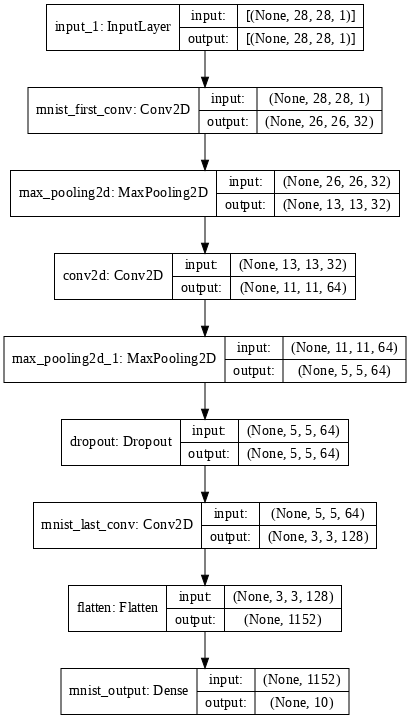

In [22]:
model_mnist = create_mnist_model("gap_shallow", (*mnist_shape, 1), mnist_num_classes, mnist_train)
# model_mnist, history_mnist = load_model("gap_shallow")

display(keras.utils.plot_model(model_mnist, show_shapes=True, dpi=72))

# train
# start_time = time.perf_counter()
# history_mnist = model_mnist.fit(mnist_train[0], mnist_train[1], batch_size=128, epochs=15, validation_split=0.1)
# print("Training took: %.2f seconds" % (time.perf_counter() - start_time))
# save_model(model_mnist, history_mnist, "gap_shallow")

# evaluate
# score_mnist = model_mnist.evaluate(mnist_test[0], mnist_test[1], verbose=0)
# plot_model_score(score_mnist, history_mnist.history)

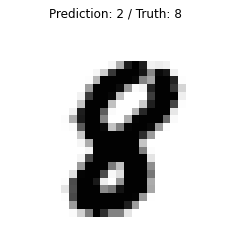

In [23]:
image, label, prediction, _ = get_prediction(model_mnist, mnist_test)
show_prediction(image, label, prediction)

#GEO

In [186]:
geo_dataset_proto = ("proto", "https://geo-cam.s3-eu-west-1.amazonaws.com/geocam.npz", ["vertical", "diagonal", "ellipse"])
geo_dataset_simple = ("simple", "https://geo-cam.s3-eu-west-1.amazonaws.com/simpledataset2_dataset.npz", ["vertical", "horizontal", "diagonal", "ellipse", "greather_than", "lower_than"])
geo_dataset_round = ("round", "https://geo-cam.s3-eu-west-1.amazonaws.com/rounddataset_dataset.npz", ["vertical", "horizontal", "diagonal", "ellipse", "greather_than", "lower_than"])
geo_dataset_threesixty = ("threesixty", "https://geo-cam.s3-eu-west-1.amazonaws.com/threesixtydataset_dataset.npz", ["10", "20", "30", "40", "50", "60", "70", "80", "90", "100", "110", "120", "130", "140", "150", "160", "170", "180"])

def get_geo_dataset(name, filepath):
  path = tf.keras.utils.get_file(name, filepath)
  with np.load(path, allow_pickle=True) as f:
    x_train, y_train = f['x_train'], f['y_train']
    x_test, y_test = f['x_test'], f['y_test']

    return (x_train, y_train), (x_test, y_test)

# dataset
dataset = geo_dataset_simple
geo_train, geo_test = get_geo_dataset(dataset[0], dataset[1])
geo_train, geo_test = format_dataset(len(dataset[2]), geo_train, geo_test)

(28, 28)
1
x_train shape: (4200, 28, 28, 1)
4200 train samples
1800 test samples


In [187]:
def create_geo_model(name, input_shape, num_classes):
  model = keras.Sequential(
      [
          keras.Input(shape=input_shape),
      
          layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu", name="geo_first_conv"),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
          layers.Dropout(0.4),
          layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
          # layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
          
          layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu", name="geo_last_conv"),
          # layers.GlobalAveragePooling2D(),
          layers.Flatten(),
          layers.Dense(num_classes, activation="softmax", name="geo_output"),
      ]
  )

  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

  return model

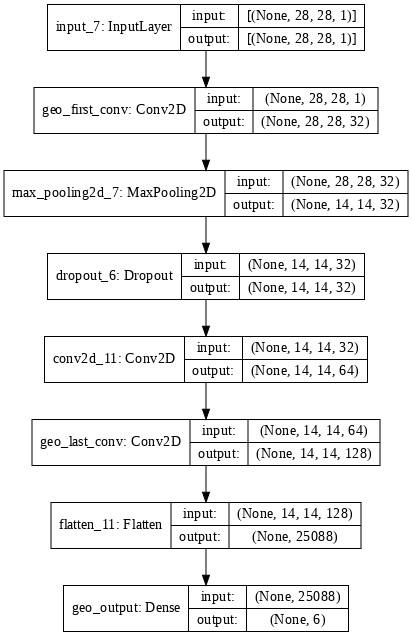

Epoch 1/15
25/25 [==============================] - 1s 19ms/step - loss: 1.5409 - accuracy: 0.3985 - val_loss: 1.0230 - val_accuracy: 0.6343
Epoch 2/15
25/25 [==============================] - 0s 10ms/step - loss: 0.8477 - accuracy: 0.7069 - val_loss: 0.3713 - val_accuracy: 0.8686
Epoch 3/15
25/25 [==============================] - 0s 11ms/step - loss: 0.3413 - accuracy: 0.8815 - val_loss: 0.2502 - val_accuracy: 0.9181
Epoch 4/15
25/25 [==============================] - 0s 10ms/step - loss: 0.2255 - accuracy: 0.9167 - val_loss: 0.1853 - val_accuracy: 0.9305
Epoch 5/15
25/25 [==============================] - 0s 10ms/step - loss: 0.1755 - accuracy: 0.9375 - val_loss: 0.1805 - val_accuracy: 0.9324
Epoch 6/15
25/25 [==============================] - 0s 11ms/step - loss: 0.1474 - accuracy: 0.9420 - val_loss: 0.1546 - val_accuracy: 0.9371
Epoch 7/15
25/25 [==============================] - 0s 10ms/step - loss: 0.1146 - accuracy: 0.9604 - val_loss: 0.1338 - val_accuracy: 0.9429
Epoch 8/15
25

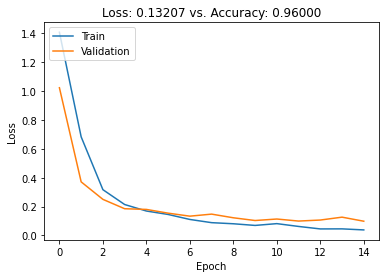

In [188]:
# model
model_geo = create_geo_model("geocam", (*mnist_shape, 1), len(dataset[2]))
# model_geo, history_geo = load_model("geo")

display(keras.utils.plot_model(model_geo, show_shapes=True, dpi=72))

start_time = time.perf_counter()
history_geo = model_geo.fit(geo_train[0], geo_train[1], batch_size=128, epochs=15, validation_split=0.25)
print("Training took: %.2f seconds" % (time.perf_counter() - start_time))
# save_model(model_geo, history_geo, "geo")

score_geo = model_geo.evaluate(geo_test[0], geo_test[1], verbose=0)
plot_model_score(score_geo, history_geo.history)

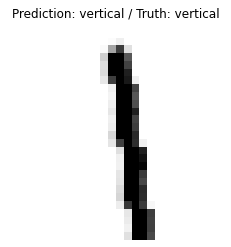

In [189]:
image, truth, prediction, _ = get_prediction(model_geo, geo_test)
show_prediction(image, truth, prediction, dataset[2])

# Transfer-learning


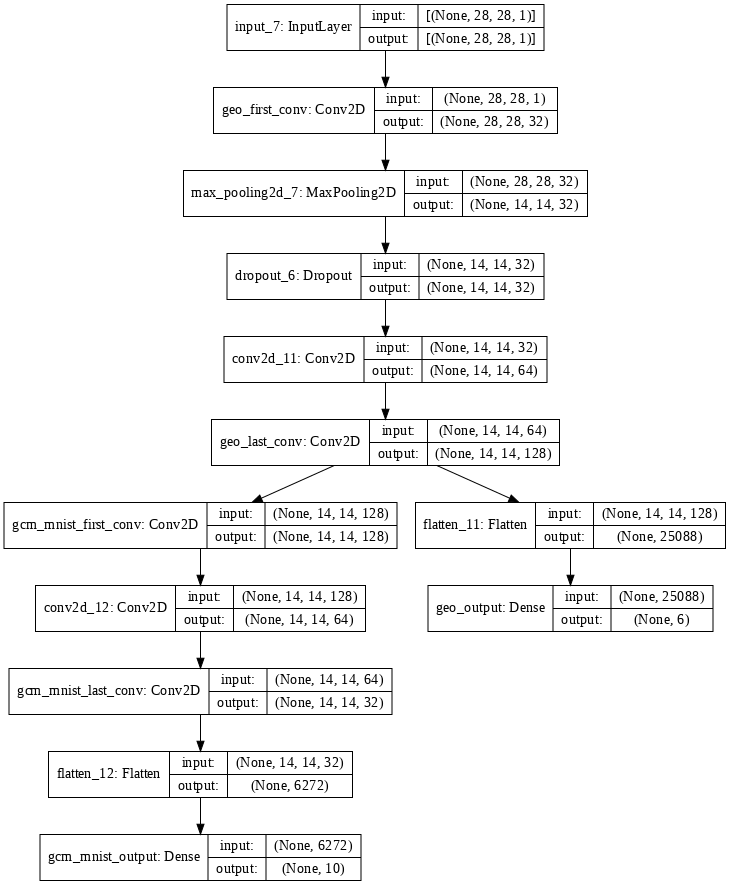

Epoch 1/5
375/375 [==============================] - 5s 11ms/step - loss: 0.5242 - accuracy: 0.8773 - val_loss: 0.0802 - val_accuracy: 0.9778
Epoch 2/5
375/375 [==============================] - 4s 11ms/step - loss: 0.0798 - accuracy: 0.9747 - val_loss: 0.0616 - val_accuracy: 0.9818
Epoch 3/5
375/375 [==============================] - 4s 11ms/step - loss: 0.0627 - accuracy: 0.9809 - val_loss: 0.0663 - val_accuracy: 0.9808
Epoch 4/5
375/375 [==============================] - 4s 11ms/step - loss: 0.0541 - accuracy: 0.9823 - val_loss: 0.0640 - val_accuracy: 0.9831
Epoch 5/5
375/375 [==============================] - 4s 11ms/step - loss: 0.0559 - accuracy: 0.9822 - val_loss: 0.0743 - val_accuracy: 0.9796
Training took: 20.42 seconds


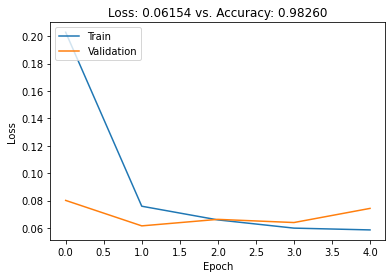

In [190]:
geo_model_copy = copy_model(model_geo, False)
input = geo_model_copy.input
geo_last, geo2_last, last = input, None, None

# utilize a lambda layer to convert the 3 channel input to a grayscale representation
# geo_last = layers.Lambda(lambda c: tf.image.rgb_to_grayscale(c))(input)

# GEO - 1
for layer in get_cam_layers(geo_model_copy)[0]:
  layer.trainable = False
  geo_last = layer(geo_last)

# MNIST - 1
last = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu", name="gcm_mnist_first_conv")(geo_last)
mnist_first_cnn = last

last = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(last)
last = layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu", name="gcm_mnist_last_conv")(last)

# MNIST - 2
last = layers.Flatten()(last)
last = layers.Dense(mnist_num_classes, activation="softmax", name="gcm_mnist_output")(last)

# CONNECTION
# connection = layers.Multiply(name="combination")([geo_last, mnist_first_cnn])
# connection.trainable = False
# mnist_first_cnn.get_output_at(1).set_weights(np.ones(mnist_first_cnn.get_output_at(1).shape))
connection = geo_last

# GEO - 2
for layer in get_cam_layers(geo_model_copy)[1]:
  layer.trainable = False
  geo2_last = layer(connection) if geo2_last is None else layer(geo2_last)

# MODEL
model_gcm = Model(inputs=input, outputs=last)
model_gcm_complete = Model(inputs=input, outputs=[last, geo2_last])

opt = keras.optimizers.Adam(learning_rate=0.004)
model_gcm.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# model_gcm_complete.summary()
display(keras.utils.plot_model(model_gcm_complete, show_shapes=True, dpi=72))

# train
start_time = time.perf_counter()
history_geocam = model_gcm.fit(mnist_train[0], mnist_train[1], batch_size=128, epochs=5, validation_split=0.2)
print("Training took: %.2f seconds" % (time.perf_counter() - start_time))

# evaluate
score_gcm = model_gcm.evaluate(mnist_test[0], mnist_test[1], verbose=0)
plot_model_score(score_gcm, history_geocam.history)

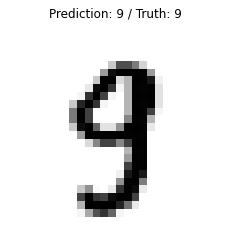

In [191]:
image, label, prediction, _ = get_prediction(model_gcm, mnist_test)
show_prediction(image, label, prediction)

# Experiments

In [192]:
# geo2 (sliced) model (from model_gcm - transfer learning) for cam prediction
model_geocam = Model([model_geo.inputs], [get_layer(model_geo, "geo_last_conv").get_output_at(0), model_geo.output])

model_gcmcam_1 = Model([model_gcm_complete.inputs], 
                     [get_layer(model_gcm_complete, "gcm_mnist_last_conv").get_output_at(0), 
                      model_gcm_complete.output])

model_gcmcam = Model([model_gcm_complete.inputs], 
                     [get_layer(model_gcm_complete, "geo_last_conv").get_output_at(0), 
                      model_gcm_complete.output])

cam_threshold = 0.7

In [193]:
def get_cam_predictions(test_image, model, classes, cam_method=grad_cam_m, threshold=180):
  cam_predictions = dict()
  cam_activations = dict()
  cam_thresholds = dict()
  min_cam_activation, max_cam_activation = 0, 0

  for category in range(classes):
    cam, _, _, _ = cam_method(test_image, model, category, 1)
    cam_activations[category] = cam
    min, max = np.min(cam), np.max(cam)
    min_cam_activation = np.minimum(min, min_cam_activation)
    max_cam_activation = np.maximum(max, max_cam_activation)

  for category in range(classes):
    cam = cam_activations[category]
    perc = safe_divide(cam - min_cam_activation, max_cam_activation - min_cam_activation, abs=False)
    
    cam = resize_image(perc, mnist_shape) * 255
    _, cam = cv.threshold(cam, threshold, 255, cv.THRESH_BINARY)
    cam_thresholds[category] = cam
    cv_img = np.array(cam, dtype = np.uint8)
    contours, _ = cv.findContours(cv_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    cam_predictions[category] = (np.max(perc), [])

    for i in range(len(contours)):
      moments = cv.moments(contours[i])
      if moments['m00'] > 0:
        center = (safe_divide(moments['m10'], moments['m00']), safe_divide(moments['m01'], moments['m00']))
        cam_predictions[category][1].append(center)
  
  return cam_activations, cam_thresholds, cam_predictions

In [194]:
def get_maskedcam_predictions(test_image, classes, cam_method=grad_cam_m, threshold=180):
  cam_predictions = dict()
  cam_activations = dict()
  cam_thresholds = dict()
  rbg_threshold = np.int0(255*threshold)

  # pure geo
  cam_geo = dict()
  cam_geo_maxes = []
  for category in range(classes):
    cam, _, _, _ = cam_method(test_image, model_geocam, category)
    cam_geo_maxes.append(np.max(cam))
    max = np.max(cam)
    min = np.min(cam)
    cam = (cam - min) / (max - min)
    cam_geo[category] = np.copy(cam)

  # gcm minist (prediction) first
  cam_mnist = dict()
  for category in range(classes):
    cam, _, _, _ = cam_method(test_image, model_gcmcam_1)
    max = np.max(cam)
    min = np.min(cam)
    cam = (cam - min) / (max - min)
    cam_mnist[category] = np.copy(cam)

  # mask
  for category in range(classes):
    modulation = safe_divide(cam_geo_maxes[category], np.max(cam_geo_maxes), abs=False) # modulation
    cam = (cam_geo[category]) - (1-cam_mnist[category]) # mask
    cam = cam * modulation
    cam_activations[category] = np.copy(cam)

  for category in range(classes):
    cam = cam_activations[category]
    cam = resize_image(cam, mnist_shape) * 255
    _, cam = cv.threshold(cam, np.int0(255*threshold), 255, cv.THRESH_BINARY)
    cam_thresholds[category] = cam
    cv_img = np.array(cam, dtype = np.uint8)
    contours, _ = cv.findContours(cv_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    cam_predictions[category] = (np.max(cam), [])

    for i in range(len(contours)):
      moments = cv.moments(contours[i])
      if moments['m00'] > 0:
        center = (safe_divide(moments['m10'], moments['m00']), safe_divide(moments['m01'], moments['m00']))
        cam_predictions[category][1].append(center)
  
  return cam_activations, cam_thresholds, cam_predictions

# _, _, _ = get_maskedcam_predictions(test_image, len(geo_labels), cam_method=grad_cam_m, threshold=.7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


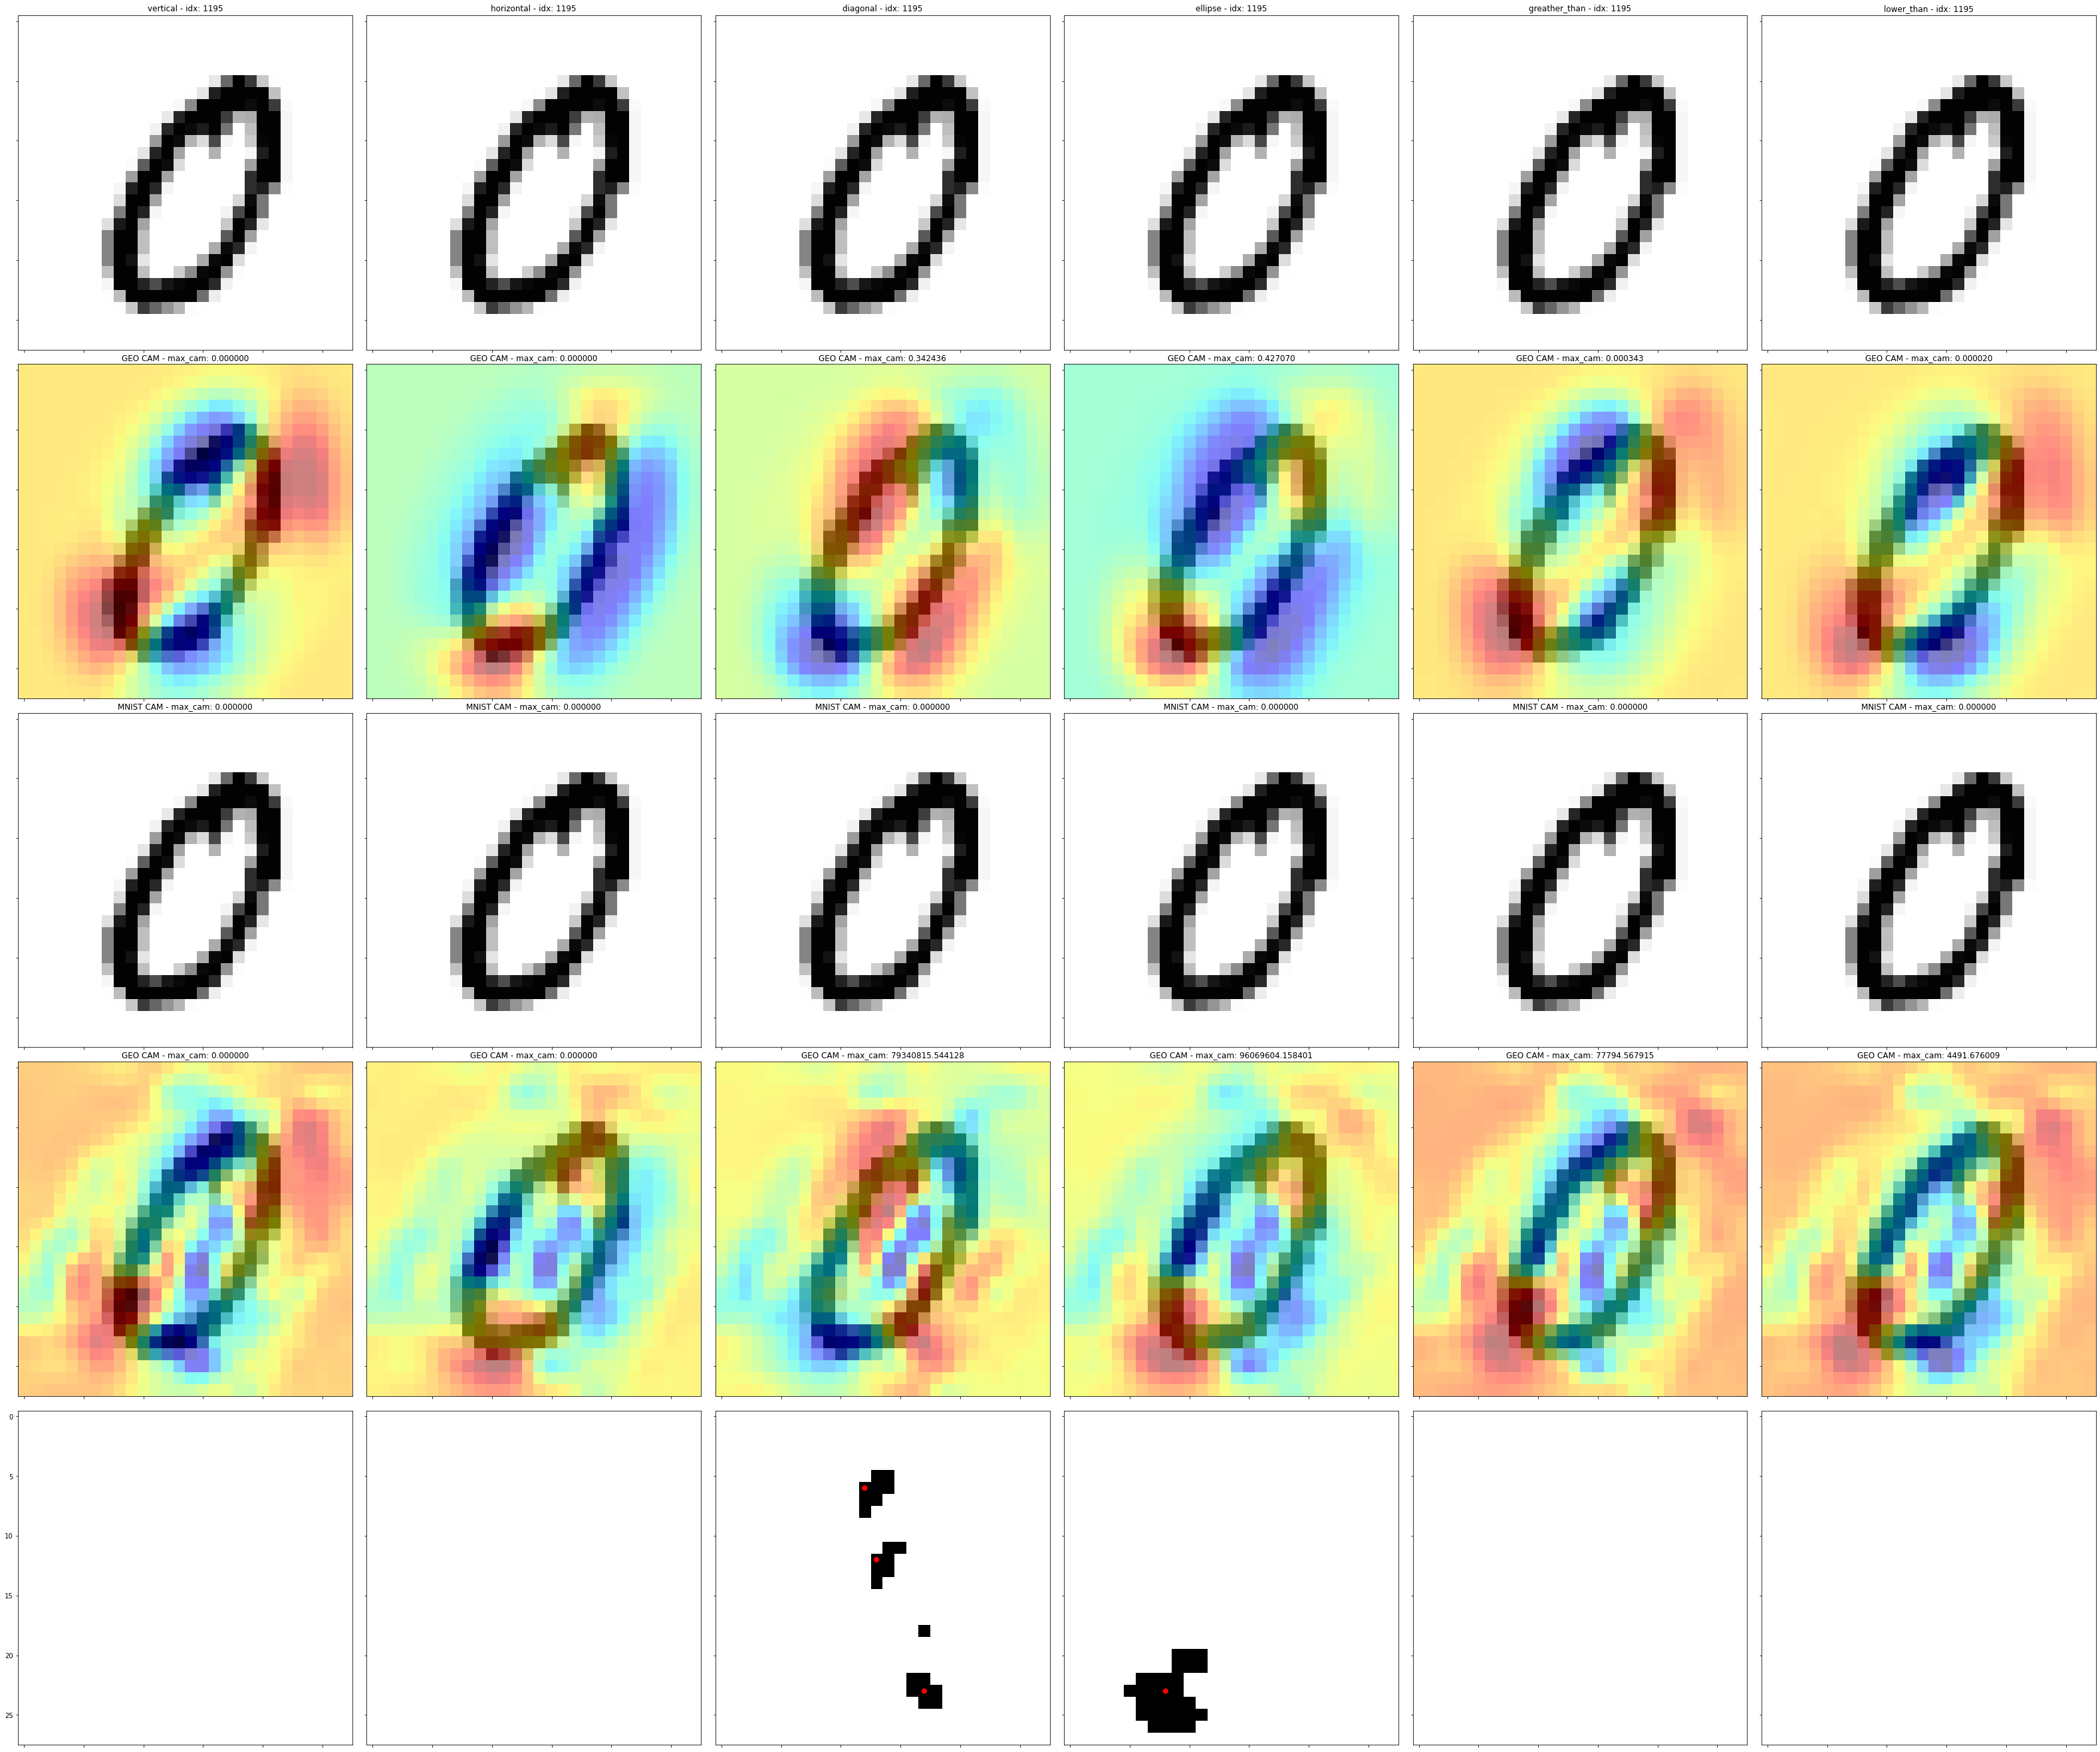

In [195]:
from mpl_toolkits.axes_grid1 import ImageGrid

# prediction based on conv output (5056, 6146, 2365, 2587, 5310, 6638)
test_image, test_label, test_idx = get_sample(mnist_test, 1195)
mnist_gcm_predictions = predict(model_gcm, test_image)
mnist_gcm_prediction = np.argmax(mnist_gcm_predictions)

assert test_label == mnist_gcm_prediction, "Missmatched ids. Wanted %d, received %d" % (test_label, mnist_gcm_prediction)

geo_labels = dataset[2]

# start plotting
image_idx = 0
fig = plt.figure(figsize=(56, 56))
grid = ImageGrid(fig, 111, nrows_ncols=(5, len(geo_labels)), axes_pad=0.3, label_mode="1")

# images
for category in range(len(geo_labels)):
  title = f"{geo_labels[category]} - idx: {test_idx}"
  show_image(test_image, mnist_shape, title, ax=grid[image_idx])
  image_idx += 1

# pure geo
cam_geo = dict()
for category in range(len(geo_labels)):
  cam, _, _, _ = grad_cam_m(test_image, model_geocam, category)
  title = f"GEO CAM - max_cam: {np.max(cam) * 100000000:.6f}"
  show_heatmap(test_image, cam, mnist_shape, True, title, ax=grid[image_idx])
  cam_geo[category] = cam
  image_idx += 1

# gcm minist (prediction) first
cam_mnist = dict()
for category in range(len(geo_labels)):
  cam, _, _, _ = grad_cam_m(test_image, model_gcmcam_1)
  title = f"MNIST CAM - max_cam: {np.max(cam) * 100000000:.6f}"
  show_heatmap(test_image, cam, mnist_shape, True, title, ax=grid[image_idx])
  cam_mnist[category] = cam
  image_idx += 1

# geocam
# cam_activations, cam_thresholded, cam_predictions = get_cam_predictions(test_image, model_gcmcam, len(geo_labels), cam_method=grad_cam_m, threshold=200)
cam_activations, cam_thresholded, cam_predictions = get_maskedcam_predictions(test_image, len(geo_labels), cam_method=grad_cam_m, threshold=cam_threshold)

for i in range(len(geo_labels)):
  cam = cam_activations[i]
  title = f"GEO CAM - max_cam: {np.max(cam) * 100000000:.6f}"
  show_heatmap(test_image, cam, mnist_shape, True, title, ax=grid[image_idx])
  image_idx += 1

# geocam areas
for i in range(len(geo_labels)):
  camt = cam_thresholded[i]
  grid[image_idx].imshow(camt, cmap='Greys')

  camp = cam_predictions[i]
  for j in range(len(camp[1])):
    camp_center = camp[1][j]
    grid[image_idx].add_patch(plt.Circle(camp_center, 0.2, color='r'))

  image_idx += 1

plt.show()

In [203]:
samples = 50
descriptions = dict()
with tqdm(total=(samples * mnist_num_classes), position=0, leave=True) as pbar:
  for category in range(mnist_num_classes):
      descriptions[category] = dict()
      decomposed_category = np.zeros(shape=(mnist_num_classes))
      decomposed_category[category] = 1

      for geo_class in range(len(dataset[2])):
          descriptions[category][dataset[2][geo_class]] = []

      for i in range(samples):
        validation_idx = random.choice(np.argwhere(np.equal(mnist_test[1], decomposed_category).all(1)))[0]
        test_image = mnist_test[0][validation_idx]

        # geo cam
        # _, _, cam_predictions = get_cam_predictions(test_image, model_gcmcam, len(dataset[2]), cam_method=grad_cam_pp_m, threshold=200)
        _, _, cam_predictions = get_maskedcam_predictions(test_image, len(geo_labels), cam_method=grad_cam_pp_m, threshold=cam_threshold)

        for key in cam_predictions:
          verbose_key = dataset[2][key]
          for pos in cam_predictions[key][1]:
            grid_position = get_grid_position(pos, mnist_shape)
            descriptions[category][verbose_key].append(grid_position)

        pbar.update()

  3%|▎         | 16/500 [00:03<01:47,  4.51it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
100%|██████████| 500/500 [01:51<00:00,  4.47it/s]


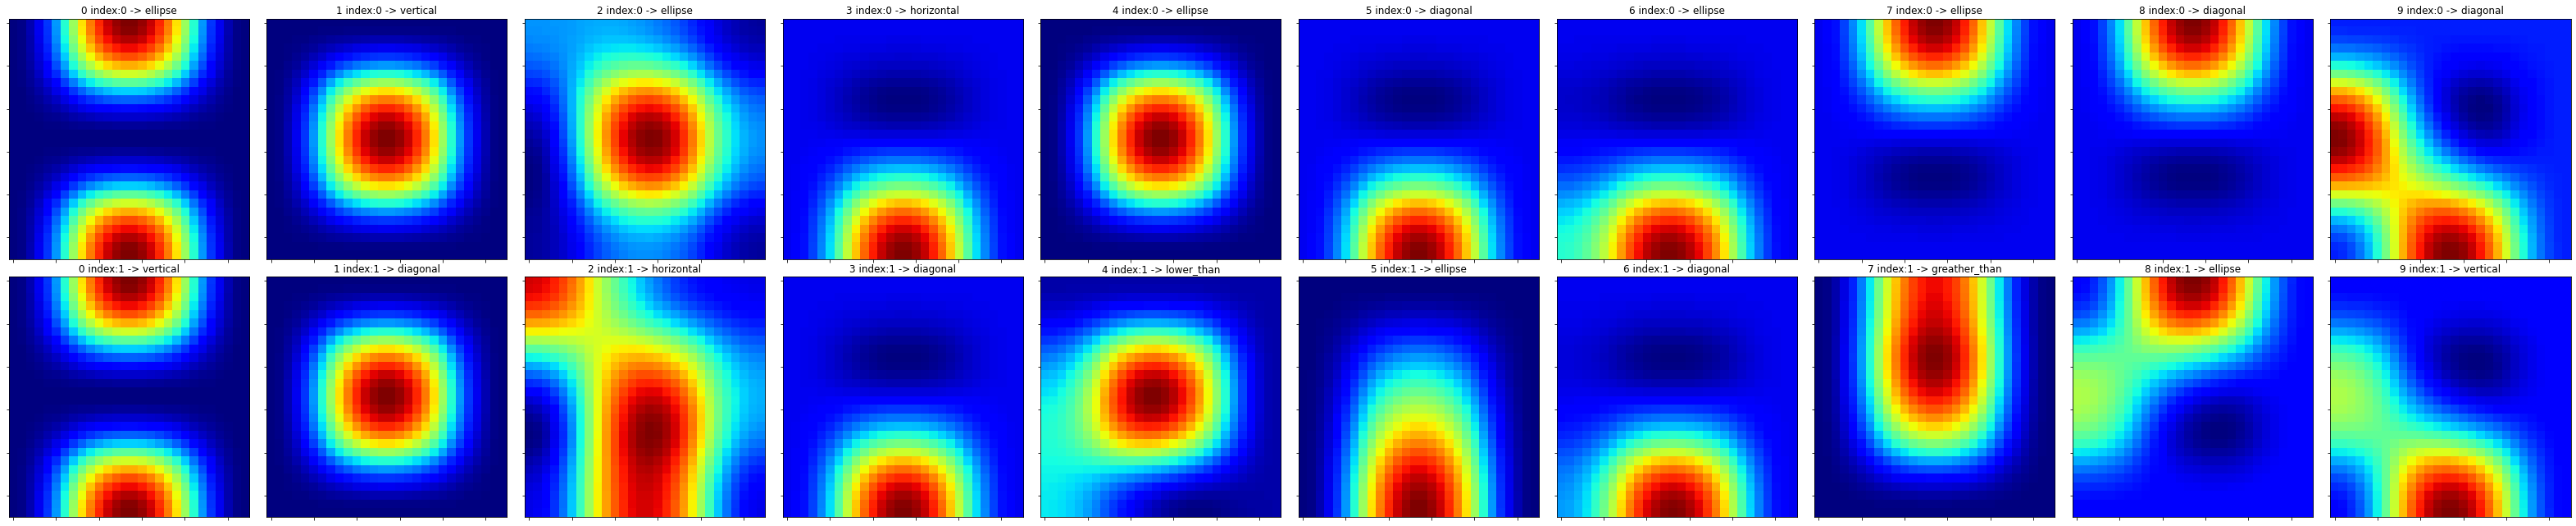

In [204]:
# heightmap
image_idx = 0
fig = plt.figure(figsize=(56, 56))
grid = ImageGrid(fig, 111, nrows_ncols=(2, mnist_num_classes), axes_pad=0.3, label_mode="1", direction='column')

for category in range(mnist_num_classes):
  heightmap = np.zeros((3, 3))
  geo_category = descriptions[category]
  index = 0
  # descriptions[category][description_position]
  for geo_cat in sorted(geo_category, key=lambda k: len(geo_category[k]), reverse=True):
    title = f"{category} index:{index} -> {geo_cat}"

    for grid_position in geo_category[geo_cat]:
      heightmap[grid_position] += 1
    
    heigthmap = get_heatmap(heightmap, mnist_shape, True)
    show_image(heigthmap, mnist_shape, title, ax=grid[image_idx], cmap='jet')
    image_idx += 1

    if index < 1: 
      index += 1
    else:
      break

plt.show()

In [198]:
print("DESCRIPTIONS:")

for category in range(mnist_num_classes):
  print(f"\n{category}")

  for description_position in descriptions[category]:
    verbose_positions = []
    grid_position = descriptions[category][description_position]
    aggregated_amount = len(grid_position)
    
    for k in grid_position:
      verbose_positions.append(get_verbose_grid_position(*k))
    
    print(f"└ {description_position}: {aggregated_amount} = {verbose_positions}")

DESCRIPTIONS:

0
└ vertical: 0 = []
└ horizontal: 1 = [('bottom', 'mid')]
└ diagonal: 2 = [('bottom', 'mid'), ('mid', 'mid')]
└ ellipse: 44 = [('bottom', 'left'), ('mid', 'right'), ('mid', 'left'), ('mid', 'right'), ('bottom', 'left'), ('bottom', 'left'), ('top', 'right'), ('top', 'right'), ('bottom', 'mid'), ('bottom', 'mid'), ('bottom', 'mid'), ('top', 'mid'), ('bottom', 'left'), ('top', 'right'), ('mid', 'mid'), ('bottom', 'left'), ('top', 'mid'), ('bottom', 'left'), ('top', 'right'), ('top', 'right'), ('top', 'right'), ('top', 'mid'), ('mid', 'right'), ('bottom', 'left'), ('bottom', 'left'), ('top', 'right'), ('top', 'right'), ('bottom', 'left'), ('bottom', 'mid'), ('bottom', 'mid'), ('top', 'mid'), ('bottom', 'mid'), ('top', 'mid'), ('bottom', 'left'), ('bottom', 'mid'), ('bottom', 'left'), ('top', 'right'), ('bottom', 'left'), ('top', 'mid'), ('bottom', 'left'), ('bottom', 'left'), ('top', 'mid'), ('bottom', 'left'), ('top', 'right')]
└ greather_than: 0 = []
└ lower_than: 1 = [('

# Metrics

In [202]:
digit_decomposition_categories = ["vertical", "horizontal", "diagonal", "ellipse", "greather_than", "lower_than"]
digits_descriptions = [
  ["ellipse"], #0
  ["vertical", "diagonal"], #1
  ["horizontal", "diagonal", "ellipse"], #2
  ["greather_than", "lower_than", "ellipse"], #3
  ["vertical", "horizontal"], #4
  ["greather_than", "ellipse", "vertical", "horizontal"], #5
  ["diagonal", "vertical", "ellipse"], #6
  ["diagonal", "vertical", "horizontal"], #7
  ["ellipse"], #8
  ["ellipse", "diagonal", "vertical"], #9
]

samples = 100
metrics, y_true, y_pred = dict(), dict(), dict()

with tqdm(total=(samples * mnist_num_classes), position=0, leave=True) as pbar:
  for category in range(mnist_num_classes):
    metrics[category] = dict()
    
    decomposed_category = np.zeros(shape=(mnist_num_classes))
    decomposed_category[category] = 1
    
    y_true[category] = np.zeros(shape=(samples))
    y_pred[category] = np.zeros(shape=(samples))

    for i in range(samples):
      validation_idx = random.choice(np.argwhere(np.equal(mnist_test[1], decomposed_category).all(1)))[0]
      test_image = mnist_test[0][validation_idx]

      # geo cam
      # _, _, cam_predictions = get_cam_predictions(test_image, model_gcmcam, len(dataset[2]), cam_method=grad_cam_m, threshold=200)
      _, _, cam_predictions = get_maskedcam_predictions(test_image, len(geo_labels), cam_method=grad_cam_pp_m, threshold=cam_threshold)

      # prediction
      y_pred[category][i] = 0
      
      for geo_label in digits_descriptions[category]:
        geo_label_idx = dataset[2].index(geo_label)
        geo_prob = cam_predictions[geo_label_idx][0]
        if len(cam_predictions[geo_label_idx][1]) > 0 and geo_prob > y_pred[category][i]:
          y_pred[category][i] = 1
      
      pbar.update()

    # metrics per category
    metrics[category]['accuracy']   = accuracy_score(y_true[category], y_pred[category])
    metrics[category]['precision']  = precision_score(y_true[category], y_pred[category], average='weighted', zero_division=0)
    metrics[category]['recall']     = recall_score(y_true[category], y_pred[category], average='weighted', zero_division=0)
    metrics[category]['f1']         = f1_score(y_true[category], y_pred[category], average='weighted', zero_division=0)

# out
print("\n\nMETRICS:")

# macro metrics
print("\nMacro:")
macro_metrics = dict()
for cat in metrics:
  for key in metrics[cat]:
    macro_metrics[key] = macro_metrics.get(key) or []
    macro_metrics[key].append(metrics[cat][key])
  
for key in macro_metrics:
  print(f"- {key}: {np.average(macro_metrics[key]):.2f}")

# micro metrics
print("\nMicro:")
for cat in metrics:
  all_metrics = ', '.join([f"{key}:{np.average(metrics[cat][key]):.2f}" for key in metrics[cat]])
  print(f"- {cat}: {all_metrics}")

  0%|          | 1/1000 [00:00<03:46,  4.42it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
100%|██████████| 1000/1000 [03:43<00:00,  4.47it/s]



METRICS:

Macro:
- accuracy: 0.96
- precision: 1.00
- recall: 0.96
- f1: 0.98

Micro:
- 0: accuracy:0.95, precision:1.00, recall:0.95, f1:0.97
- 1: accuracy:0.98, precision:1.00, recall:0.98, f1:0.99
- 2: accuracy:0.97, precision:1.00, recall:0.97, f1:0.98
- 3: accuracy:0.92, precision:1.00, recall:0.92, f1:0.96
- 4: accuracy:0.99, precision:1.00, recall:0.99, f1:0.99
- 5: accuracy:0.93, precision:1.00, recall:0.93, f1:0.96
- 6: accuracy:0.91, precision:1.00, recall:0.91, f1:0.95
- 7: accuracy:0.97, precision:1.00, recall:0.97, f1:0.98
- 8: accuracy:0.96, precision:1.00, recall:0.96, f1:0.98
- 9: accuracy:0.97, precision:1.00, recall:0.97, f1:0.98


# Archive

In [200]:
raise Exception('do not run any further')

Exception: ignored

In [ ]:
# Predictions
_, predictions = model_gcmcam(np.expand_dims(test_image, 0))
sorted_indexes = np.flip(np.argsort(predictions[1][0]))
percentages = np.round(predictions[1][0] / predictions[1][0][sorted_indexes[0]], 5)

print(f"1st : {dataset[2][sorted_indexes[0]]} ({percentages[sorted_indexes[0]] * 100:.2f}%)")
print(f"2nd : {dataset[2][sorted_indexes[1]]} ({percentages[sorted_indexes[1]] * 100:.2f}%)")
print(f"3rd : {dataset[2][sorted_indexes[2]]} ({percentages[sorted_indexes[2]] * 100:.2f}%)")

In [ ]:
# verifying transfer learning
print(f"geo conv weights: {hashlib.sha256(get_layer(model_geo, 'geo_last_conv').get_weights()[0]).hexdigest().upper()}")
print(f"gcm1 conv weights: {hashlib.sha256(get_layer(model_gcm, 'geo_last_conv').get_weights()[0]).hexdigest().upper()}")
print(f"gcm2 conv weights: {hashlib.sha256(get_layer(model_gcm_complete, 'geo_last_conv').get_weights()[0]).hexdigest().upper()}")

print(f"geo conv biases: {hashlib.sha256(get_layer(model_geo, 'geo_last_conv').get_weights()[1]).hexdigest().upper()}")
print(f"gcm1 conv biases: {hashlib.sha256(get_layer(model_gcm, 'geo_last_conv').get_weights()[1]).hexdigest().upper()}")
print(f"gcm2 conv biases: {hashlib.sha256(get_layer(model_gcm_complete, 'geo_last_conv').get_weights()[1]).hexdigest().upper()}")

test_image, test_label, test_idx = get_sample(mnist_test)
test_geo = Model([model_geo.inputs], [get_layer(model_geo, 'geo_last_conv').get_output_at(0), model_geo.output])
test_gcm = Model([model_gcm_complete.inputs], [get_layer(model_gcm_complete, 'geo_last_conv').get_output_at(1), 
                                               get_layer(model_gcm_complete, "geo_output").get_output_at(0)])
test_gcm_ = Model([model_gcm_complete.inputs], [get_layer(model_gcm_complete, 'gcm_mnist_first_conv').get_output_at(0), 
                                               get_layer(model_gcm_complete, "geo_output").get_output_at(0)])

print(f"geo conv activations: {hashlib.sha256(test_geo(np.expand_dims(test_image, 0))[0]).hexdigest().upper()}")
print(f"gcm conv activations: {hashlib.sha256(test_gcm(np.expand_dims(test_image, 0))[0]).hexdigest().upper()}")
print(f"gcm alterate conv activations: {hashlib.sha256(test_gcm_(np.expand_dims(test_image, 0))[0]).hexdigest().upper()}")

In [ ]:
# debugging cams and values
test_ids = {
        "1": 3455,
        "4": 6195,
        "0": 3710,
        "6": 6187,
        "7": 6606,
        "5": 6148,
        "9": 5622,
    }

test_idx = 6
test_mnist_idx = test_ids[f"{test_idx}"]
test_mnist_image = mnist_test[0][test_mnist_idx]
# show_image(test_mnist_image)

# GCM (Transfer learned network - init geo, end mnist)
# gcm_mnist_image, _, prediction, test_img_idx = get_prediction(model_gcm, mnist_test, test_idx)
# gcm_prediction_idx = np.argmax(prediction)
gcm_mnist_cam, gcm_conv_output, gcm_mnist_prediction, _ = grad_cam_pp(test_mnist_image, model_gcm, -3)
print(f"conv output hash: {hashlib.sha256(gcm_conv_output.numpy()).hexdigest().upper()}")

title = f"MNIST prediction: {gcm_mnist_prediction} (truth: {test_idx})"
show_heatmap(test_mnist_image, gcm_mnist_cam, mnist_shape, True, title)

assert test_idx == gcm_mnist_prediction, "Missmatched ids. Wanted %d, received %d" % (test_idx, gcm_mnist_prediction)

In [ ]:
# 1) prediction based on conv output
test_image, test_label = get_sample(mnist_test)

cam_layer = get_cam_layer(model_gcm, "conv2d_5")
cam_model = Model([model_gcm.inputs], [cam_layer.get_output_at(1), model_gcm.output])
gcm_mnist_cam, gcm_conv_output, gcm_mnist_prediction, _ = grad_cam_pp_m(test_image, cam_model)
# print(f"conv output hash: {hashlib.sha256(gcm_conv_output.numpy()).hexdigest().upper()}")
assert test_label == gcm_mnist_prediction, "Missmatched ids. Wanted %d, received %d" % (test_idx, test_label)

# Prediction
labels = dataset[2]
gcg_predictions = model_geo_2.predict(gcm_conv_output)
sorted_indexes = np.flip(np.argsort(gcg_predictions[0]))
percentages = gcg_predictions[0] / gcg_predictions[0][sorted_indexes[0]]

print(f"1st : {labels[sorted_indexes[0]]} ({percentages[sorted_indexes[0]] * 100:.2f}%)")
print(f"2nd : {labels[sorted_indexes[1]]} ({percentages[sorted_indexes[1]] * 100:.2f}%)")
print(f"3rd : {labels[sorted_indexes[2]]} ({percentages[sorted_indexes[2]] * 100:.2f}%)")

# Debug (CAM projection)
gcg_mnist_cam = cam_1(model_geo, gcm_conv_output, sorted_indexes[0])
show_heatmap(test_image, gcg_mnist_cam, mnist_shape, True)

In [ ]:
# 2) prediction based on cam heatmap (SHOULD NOT WORK)

test_image, test_label = get_sample(mnist_test, 6187)
gcm_mnist_cam, gcm_conv_output, gcm_mnist_prediction, _ = grad_cam_pp(test_image, model_gcm)
heatmap = get_heatmap(gcm_mnist_cam, mnist_shape).reshape(*mnist_shape, 1) * 255
prediction = predict(model_geo, heatmap)

show_image(heatmap)

labels = dataset[2]
sorted_indexes = np.flip(np.argsort(prediction[0]))
percentages = prediction[0] / prediction[0][sorted_indexes[0]]

print(f"1st : {labels[sorted_indexes[0]]} ({percentages[sorted_indexes[0]] * 100:.2f}%)")
print(f"2nd : {labels[sorted_indexes[1]]} ({percentages[sorted_indexes[1]] * 100:.2f}%)")
print(f"3rd : {labels[sorted_indexes[2]]} ({percentages[sorted_indexes[2]] * 100:.2f}%)")

plt.figure(facecolor='white')
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.imshow(test_image.reshape(*mnist_shape), alpha=0.5, cmap='Greys')
plt.imshow(heatmap.reshape(*mnist_shape), cmap='jet', alpha=0.5)
plt.show()  